In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import os
import time

import keras
from keras.optimizers import Adadelta
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
#%matplotlib notebook

# Data Processing

In [2]:
classes = os.listdir('by_class')

data_sets = {}
data_pairs = []
for class_int, class_dir in enumerate(classes):
    image_path = 'by_class/{}/train_{}/'.format(class_dir, class_dir)
    image_files = os.listdir(image_path)
    full_paths = [image_path + img for img in image_files]
    data_sets[class_dir] = full_paths
    for d in full_paths:
        data_pairs.append((d, class_int))
        
x_data = np.array(data_pairs)[::,0]
y_data = keras.utils.to_categorical(np.array(data_pairs)[::,1], len(classes))

In [3]:
full_idx = np.arange(0, len(x_data))
train_idx = np.random.choice(full_idx, int(len(x_data)*0.8), 
                             replace=False)
test_idx = np.setdiff1d(full_idx, train_idx)

x_train = x_data[train_idx]
y_train = y_data[train_idx]
x_test = x_data[test_idx]
y_test = y_data[test_idx]

53


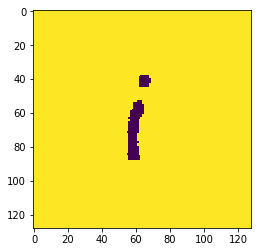

In [4]:
im = imageio.imread(data_pairs[591000][0], pilmode='L')/255
print(data_pairs[590000][1])
plt.imshow(im)

In [5]:
def batch_generator(x, y, batch_size=32, iterate=False):
    count = 0
    while True:
        idx = np.random.randint(0, len(x), batch_size)
        if iterate:
            idx = np.arange(count*batch, (count+1)*batch)
            if idx[-1] > len(x):
                yield np.array([]), np.array([])
        im_files = x[idx]
        ims = []
        labels = y[idx]
        
        for i in im_files:
            image = imageio.imread(i, pilmode='L')/255
            image = np.expand_dims(image, axis=0)
            ims.append(image)

        yield np.array(ims), labels

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
17


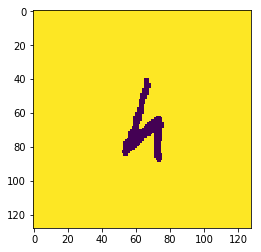

In [6]:
# quick test
for gen, label in batch_generator(x_train, y_train):
    for im, l in zip(gen, label):
        print(l)
        print(np.argmax(l))
        plt.imshow(im.reshape(128,128))
        plt.show()
        break
    break

# Model

In [7]:
img_rows, img_cols = 128, 128
input_shape = (1, img_rows, img_cols)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 data_format="channels_first"))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

adadelta = Adadelta(lr=0.1)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['categorical_accuracy'])

# Training

In [43]:
callback_list = []
callback_list.append(EarlyStopping(monitor='val_loss', patience=10))
callback_list.append(TensorBoard(log_dir='./logs/' + str(int(time.time()))))

train_gen = batch_generator(x_train, y_train, batch_size=32)
test_gen = batch_generator(x_test, y_test, batch_size=32)

hist = model.fit_generator(generator=train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=8,
                    validation_steps=8,
                    epochs=100,
                    verbose=1,
                    callbacks=callback_list)

Epoch 1/1
8/8 [==============================] - 21s 3s/step - loss: 2.1920 - categorical_accuracy: 0.4062 - val_loss: 1.8106 - val_categorical_accuracy: 0.5391


# Evaluation

<IPython.core.display.Javascript object>


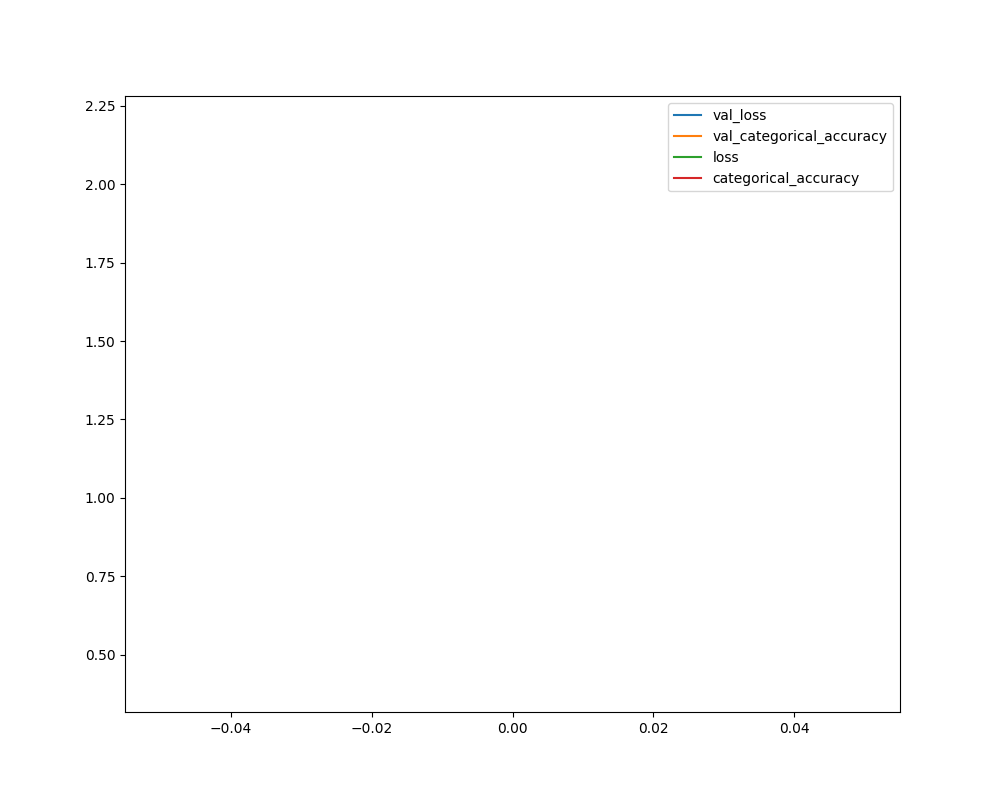

In [44]:
df = pd.DataFrame(hist.history)
df.plot(figsize=(10,8))

In [9]:
score = model.evaluate_generator(test_gen, steps=10, verbose=0)
print('Test loss:', score[0])
print('Test categorical accuracy:', score[1])

Test loss: 1.7867539763450622
Test categorical accuracy: 0.578125


In [10]:
for x, y in test_gen:
    pred = model.predict(x)
    for xp, l in zip(pred, y):
        print("Predicition:", np.argmax(xp))
        print("Actual     :", np.argmax(l))
        print("----------------------")
    break

Predicition: 30
Actual     : 30
----------------------
Predicition: 29
Actual     : 29
----------------------
Predicition: 58
Actual     : 58
----------------------
Predicition: 30
Actual     : 30
----------------------
Predicition: 56
Actual     : 12
----------------------
Predicition: 60
Actual     : 60
----------------------
Predicition: 13
Actual     : 13
----------------------
Predicition: 2
Actual     : 0
----------------------
Predicition: 60
Actual     : 60
----------------------
Predicition: 26
Actual     : 26
----------------------
Predicition: 20
Actual     : 20
----------------------
Predicition: 56
Actual     : 56
----------------------
Predicition: 37
Actual     : 37
----------------------
Predicition: 49
Actual     : 32
----------------------
Predicition: 13
Actual     : 13
----------------------
Predicition: 57
Actual     : 57
----------------------
Predicition: 49
Actual     : 17
----------------------
Predicition: 29
Actual     : 42
----------------------
Predicition:

# Confusion Matrix

In [41]:
all_gen = batch_generator(x_test, y_test, batch_size = 100)
y_true = np.array([])
y_pred = np.array([])

for x, y in all_gen:
    if not y_true.size:
        y_true = y_true.reshape((0, y.shape[1]))
        y_pred = y_true.reshape((0, y.shape[1]))

    y_true = np.concatenate((y_true, y))
    
    _y = model.predict(x)
    y_pred = np.concatenate((y_pred, _y))
    
    if len(y_true) == 1000:
        break

<IPython.core.display.Javascript object>


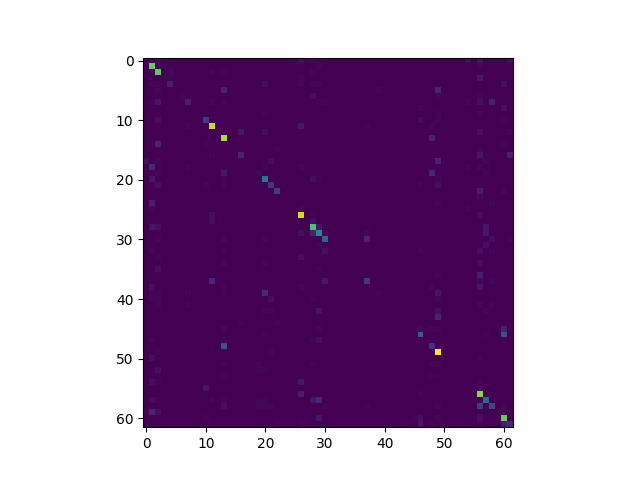

In [42]:
cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
plt.imshow(cm)

# Tensorboard Results

<IPython.core.display.Javascript object>


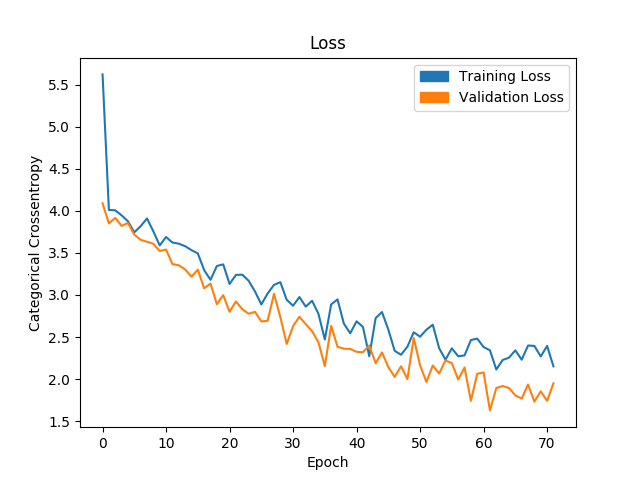

In [36]:
df_loss = pd.read_csv('run_1536441301-tag-loss.csv')
df_val_loss = pd.read_csv('run_1536441301-tag-val_loss.csv')

plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical Crossentropy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Loss'),
    mpatches.Patch(color='C1', label='Validation Loss')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)

<IPython.core.display.Javascript object>


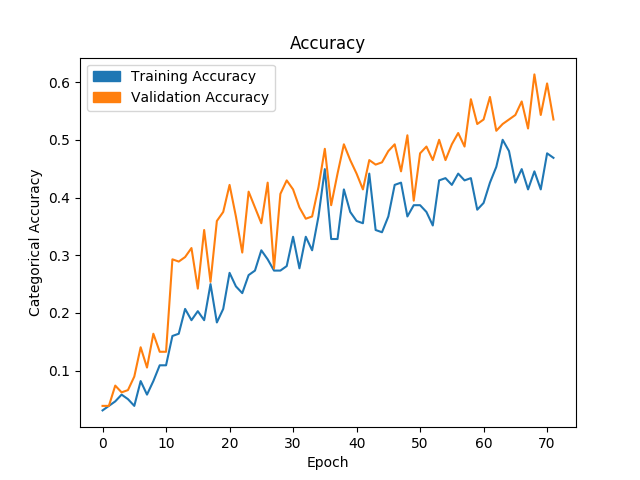

In [38]:
df_loss = pd.read_csv('run_1536441301-tag-categorical_accuracy.csv')
df_val_loss = pd.read_csv('run_1536441301-tag-val_categorical_accuracy.csv')

plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Accuracy'),
    mpatches.Patch(color='C1', label='Validation Accuracy')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)